In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import lingam
from lingam import DirectLiNGAM
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from cdt.metrics import SHD
from sklearn.metrics import precision_score, recall_score, f1_score
from causallearn.utils.GraphUtils import GraphUtils







df = pd.read_csv('CNC_Machine.csv')
df_clean = df.drop(columns=["Unnamed: 0", "filename", "start_time", "end_time", "edge", "meterID"])
df_clean.fillna(df_clean.median(), inplace=True)



No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [2]:
target = "average_power_consumption"
X = df_clean.drop(columns=[target])
y = df_clean[target]
feature_names = df_clean.columns.tolist()


In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


scaler_y = MinMaxScaler(feature_range=(0, 1))  # Normalize between 0 and 1
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()




In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

In [5]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

In [6]:
class CNCCausalModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.adjacency = nn.Parameter(torch.randn(input_dim, input_dim))  
        nn.init.xavier_uniform_(self.adjacency)  
        
        #Deeper network with more neurons
        self.shared_net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2), 
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.target_net = nn.Linear(64, 1)

    def forward(self, x):
        # W = torch.tanh(self.adjacency) 
        W = torch.tanh(self.adjacency) * (1 - torch.eye(self.adjacency.shape[0])) 
        masked_input = torch.matmul(x, W)
        shared = self.shared_net(masked_input)
        return self.target_net(shared)


In [7]:
model = CNCCausalModel(X_scaled.shape[1])
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)  
criterion = nn.HuberLoss(delta=1.0)  

In [8]:
# X_tensor = torch.FloatTensor(X_scaled)
# y_tensor = torch.FloatTensor(y_scaled)

In [9]:
loss_values = []
dag_values = []
for epoch in range(3000):  
    optimizer.zero_grad()
    
    pred = model(X_train_tensor)
    loss = criterion(pred, y_train_tensor)
    
    
    W = torch.sigmoid(model.adjacency)
    h = torch.trace(torch.matrix_exp(W * W)) - W.shape[0]

    loss += 0.1 * h * h  
    
    loss += 0.05 * torch.norm(model.adjacency, p=1)

    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    dag_values.append(h.item())
    # scheduler.step()

    # if epoch % 500 == 0:
    #     print(f"Epoch {epoch}: Loss={loss.item():.6f}, DAG Loss={h.item():.6f}")


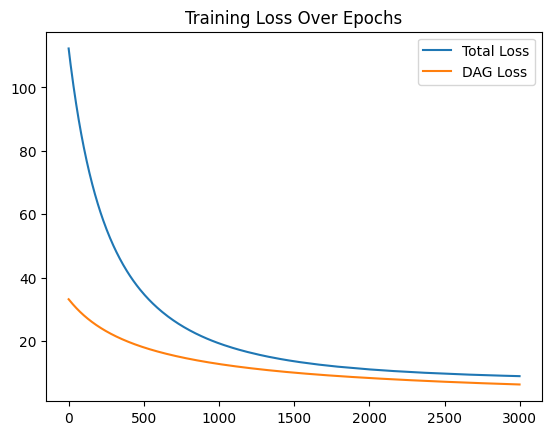

In [10]:
plt.plot(loss_values, label="Total Loss")
plt.plot(dag_values, label="DAG Loss")
plt.legend()
plt.title("Training Loss Over Epochs")
plt.show()

In [11]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    adj_matrix = torch.sigmoid(model.adjacency).numpy()

    W_val = torch.sigmoid(model.adjacency)
    h_val = torch.trace(torch.matrix_exp(W_val * W_val)) - W_val.shape[0]
    


y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))


In [12]:
print("y mean:", y.mean(), "y std:", y.std())
print("y_scaled mean:", y_scaled.mean(), "y_scaled std:", y_scaled.std())


y mean: 2835.3724582008444 y std: 720.7970690058299
y_scaled mean: 0.457528488253665 y_scaled std: 0.2565619710294054


In [13]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f"R²: {r2:.3f}, MAE: {mae:.2f} kW")

R²: 0.925, MAE: 138.01 kW


In [14]:
feature_names = [col for col in df_clean.columns if col != target]
print("Features:", feature_names)
print("Number of features:", len(feature_names))

Features: ['processing_time', 'missing_data', 'raw_volume', 'lines_of_code', 'tool_changes', 'travels_to_zero_point_in_rapid_traverse', 'axes_rotation', 'weighted_rotational_speed', 'weighted_tool_diameter', 'weighted_cutting_length', 'weighted_number_of_cutting_edges', 'weighted_cutting_speed', 'weighted_feed_per_tooth', 'weighted_feed_rate']
Number of features: 14


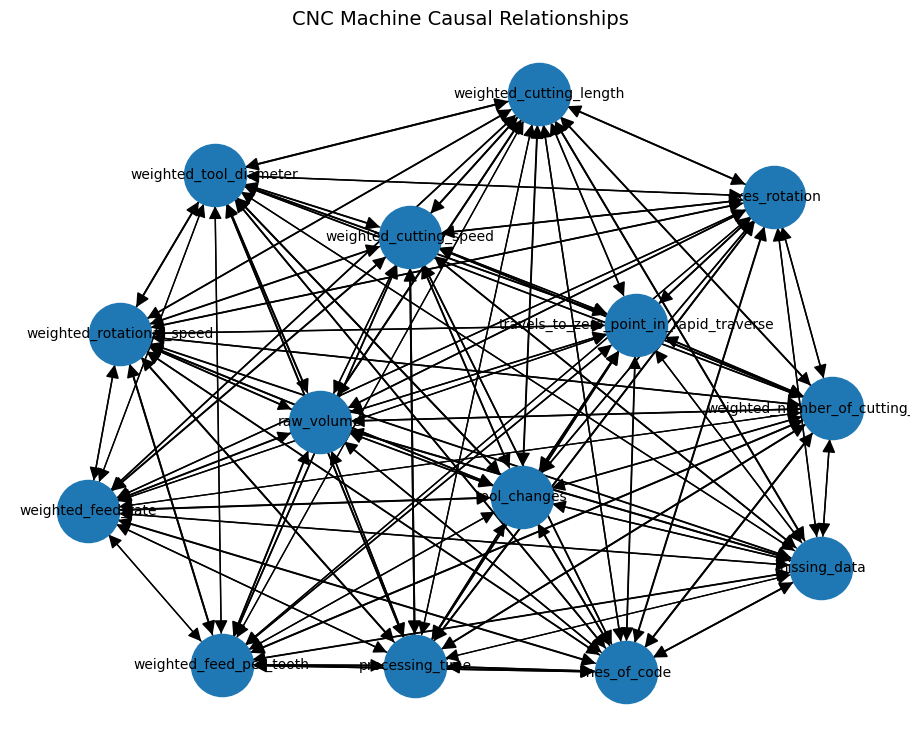

In [15]:
G = nx.DiGraph()
threshold = 0.2 

for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        if adj_matrix[i, j] > threshold and i != j:
            G.add_edge(feature_names[i], feature_names[j], weight=adj_matrix[i, j])

plt.figure(figsize=(9, 7))
pos = nx.spring_layout(G, k=0.7)
nx.draw(G, pos, with_labels=True, 
        node_size=2000,
        width=[G[u][v]['weight']*3 for u, v in G.edges],
        arrowsize=20,
        font_size=10)
plt.title("CNC Machine Causal Relationships", fontsize=14)
plt.show()

In [16]:
feature_importance = adj_matrix.mean(axis=1)  
results = pd.DataFrame({
    'Feature': feature_names,
    'Causal_Weight': feature_importance
}).sort_values('Causal_Weight', key=abs, ascending=False)

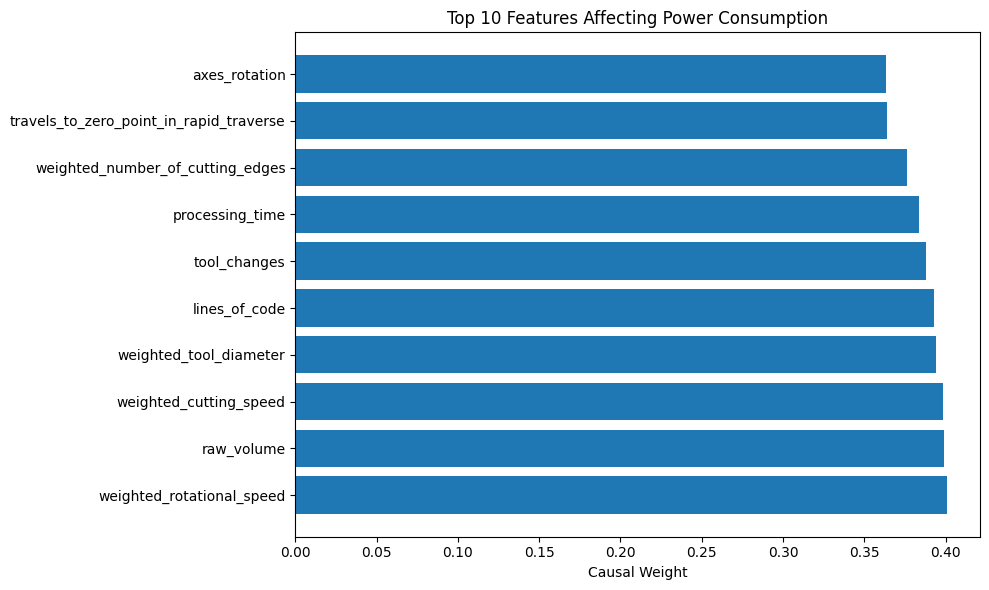

In [17]:
plt.figure(figsize=(10, 6))
plt.barh(results['Feature'].head(10), results['Causal_Weight'].head(10))
plt.xlabel('Causal Weight')
plt.title('Top 10 Features Affecting Power Consumption')
plt.tight_layout()
plt.show()

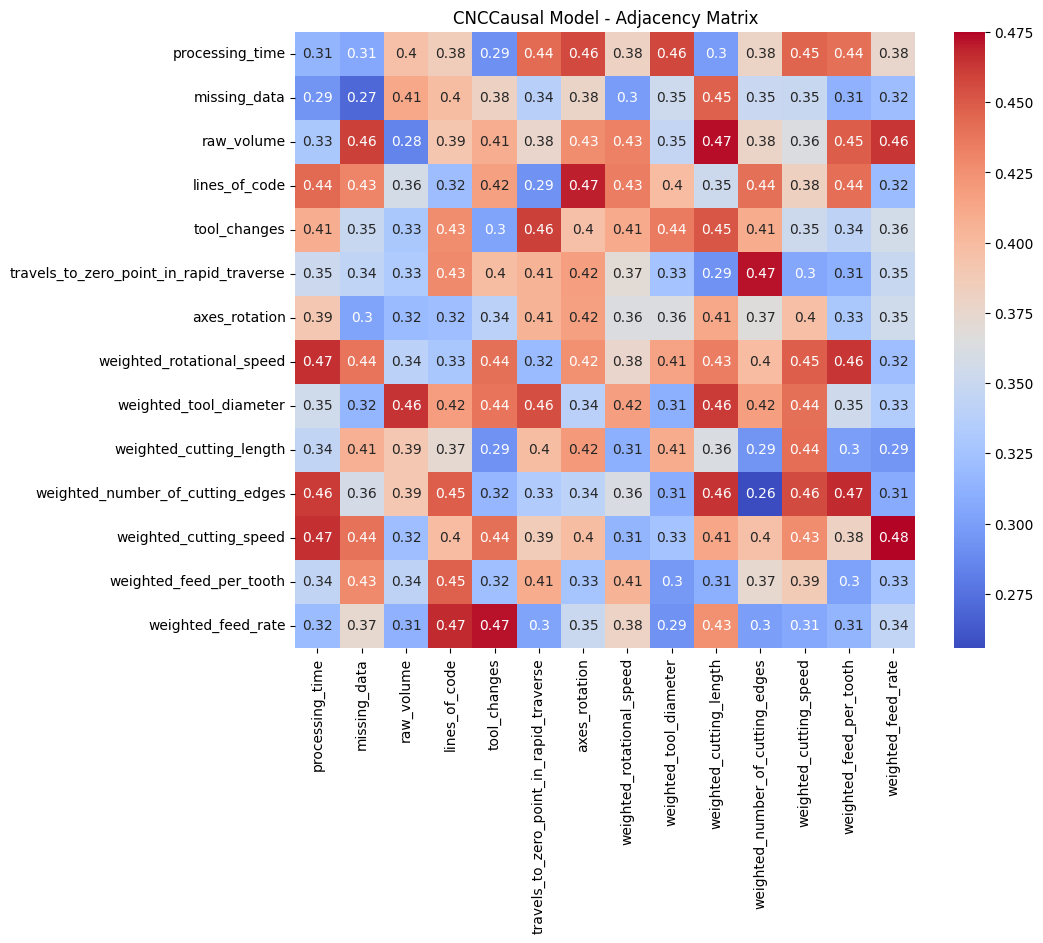

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(adj_matrix, xticklabels=feature_names, yticklabels=feature_names, cmap="coolwarm", annot=True)
plt.title("CNCCausal Model - Adjacency Matrix")
plt.show()

In [19]:
ground_truth_graph = nx.DiGraph([
    ("weighted_cutting_speed", target),
    ("weighted_rotational_speed", target),
    ("processing_time", target)
])

In [20]:
def get_top_k_edges(adj_matrix, feature_names, k=15):  
    edges = []
    for i in range(adj_matrix.shape[0]):
        for j in range(adj_matrix.shape[1]):
            if i != j:
                edges.append((feature_names[i], feature_names[j], adj_matrix[i, j]))
    edges.sort(key=lambda x: x[2], reverse=True)
    return edges[:k]


true_edge_count = len(ground_truth_graph.edges())
top_edges = get_top_k_edges(adj_matrix, feature_names, k=true_edge_count)
# top_edges = get_top_k_edges(adj_matrix, feature_names)
G = nx.DiGraph()
for src, tgt, weight in top_edges:
    G.add_edge(src, tgt, weight=weight)


target = "average_power_consumption"
if target not in G.nodes():
    G.add_node(target)
if target not in ground_truth_graph.nodes():
    ground_truth_graph.add_node(target)


# true_edges = ground_truth_graph.edges()
# pred_edges = G.edges()


In [21]:
def calculate_edge_metrics(true_edges, pred_edges):
    """Compute precision, recall, F1 for edges."""
    true_edges = set(true_edges)
    pred_edges = set(pred_edges)
    
    nodes = sorted(list(set([n for edge in true_edges | pred_edges for n in edge])))
    n = len(nodes)
    true_mat = np.zeros((n, n))
    pred_mat = np.zeros((n, n))
    
    node_to_idx = {node: i for i, node in enumerate(nodes)}
    
    for src, tgt in true_edges:
        true_mat[node_to_idx[src], node_to_idx[tgt]] = 1
        
    for src, tgt in pred_edges:
        if src in node_to_idx and tgt in node_to_idx:  
            pred_mat[node_to_idx[src], node_to_idx[tgt]] = 1
    
    true_flat = true_mat.flatten()
    pred_flat = pred_mat.flatten()
    
    precision = precision_score(true_flat, pred_flat)
    recall = recall_score(true_flat, pred_flat)
    f1 = f1_score(true_flat, pred_flat)
    
    return precision, recall, f1

true_edges = ground_truth_graph.edges()
pred_edges = G.edges()

precision, recall, f1 = calculate_edge_metrics(true_edges, pred_edges)

common_nodes = set(ground_truth_graph.nodes()) & set(G.nodes())

true_subgraph = ground_truth_graph.subgraph(common_nodes).copy()
pred_subgraph = G.subgraph(common_nodes).copy()

shd_value = SHD(true_subgraph, pred_subgraph)

print("\nCausal Graph Metrics:")
print(f"- Precision: {precision:.3f} (Fraction of predicted edges that are correct)")
print(f"- Recall: {recall:.3f} (Fraction of true edges recovered)")
print(f"- F1: {f1:.3f} (Harmonic mean of precision/recall)")
print(f"- SHD: {shd_value} (Structural Hamming Distance - computed on common nodes only)")

print("\nPredictive Metrics:")
print(f"- R²: {r2_score(y_test_rescaled, y_pred_rescaled):.3f}")
print(f"- MAE: {mean_absolute_error(y_test_rescaled, y_pred_rescaled):.2f} kW")


Causal Graph Metrics:
- Precision: 0.000 (Fraction of predicted edges that are correct)
- Recall: 0.000 (Fraction of true edges recovered)
- F1: 0.000 (Harmonic mean of precision/recall)
- SHD: 1.0 (Structural Hamming Distance - computed on common nodes only)

Predictive Metrics:
- R²: 0.925
- MAE: 138.01 kW


In [22]:
print("\nGround Truth Graph Edges:", list(ground_truth_graph.edges()))
print("\nPredicted Graph Edges:", list(G.edges()))


Ground Truth Graph Edges: [('weighted_cutting_speed', 'average_power_consumption'), ('weighted_rotational_speed', 'average_power_consumption'), ('processing_time', 'average_power_consumption')]

Predicted Graph Edges: [('weighted_cutting_speed', 'weighted_feed_rate'), ('weighted_feed_rate', 'tool_changes'), ('raw_volume', 'weighted_cutting_length')]


In [23]:
def sensitivity_analysis(model, X_test_tensor, y_test_tensor, feature_names, perturbation_factor=0.05):

    sensitivity_scores = {}

    for idx, feature in enumerate(feature_names):
        perturbed_X_test = X_test_tensor.clone()
        
        
        perturbation = perturbation_factor * X_test_tensor[:, idx].mean()
        perturbed_X_test[:, idx] += perturbation

        
        with torch.no_grad():
            original_pred = model(X_test_tensor)
            perturbed_pred = model(perturbed_X_test)

        
        change_in_prediction = torch.abs(perturbed_pred - original_pred).mean().item()

        sensitivity_scores[feature] = change_in_prediction

   
    sorted_sensitivity = sorted(sensitivity_scores.items(), key=lambda x: x[1], reverse=True)

    return sorted_sensitivity


In [24]:
sensitivity_results = sensitivity_analysis(model, X_test_tensor, y_test_tensor, feature_names)

print("Feature Sensitivity Scores:")
for feature, score in sensitivity_results:
    print(f"{feature}: {score:.4f}")


Feature Sensitivity Scores:
weighted_number_of_cutting_edges: 0.0015
weighted_feed_per_tooth: 0.0010
lines_of_code: 0.0009
weighted_feed_rate: 0.0006
processing_time: 0.0004
weighted_tool_diameter: 0.0003
missing_data: 0.0003
travels_to_zero_point_in_rapid_traverse: 0.0003
axes_rotation: 0.0002
weighted_rotational_speed: 0.0002
tool_changes: 0.0001
weighted_cutting_speed: 0.0001
weighted_cutting_length: 0.0001
raw_volume: 0.0000


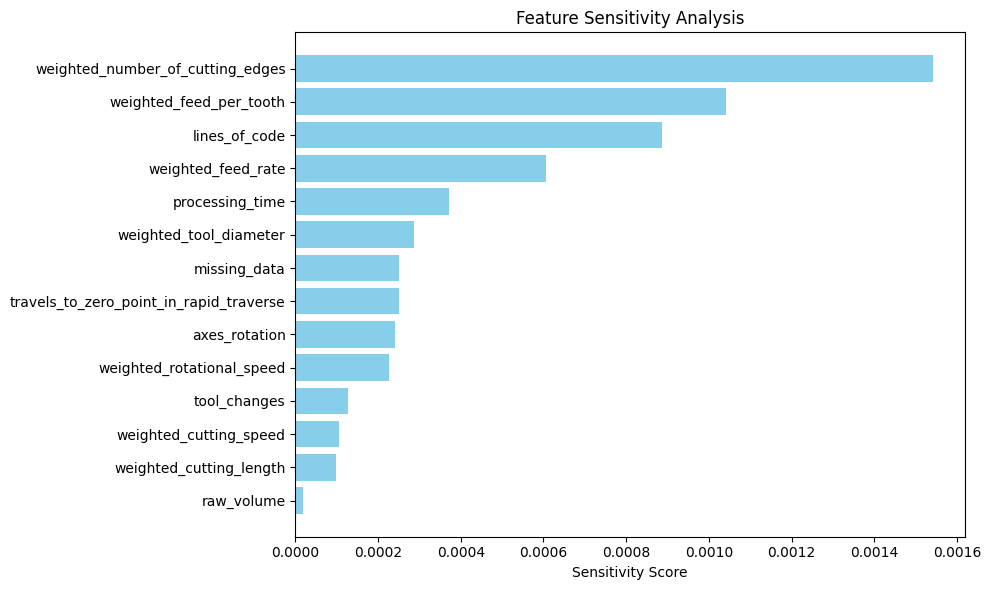

In [25]:
features, sensitivity = zip(*sensitivity_results)

plt.figure(figsize=(10, 6))
plt.barh(features, sensitivity, color='skyblue')
plt.xlabel("Sensitivity Score")
plt.title("Feature Sensitivity Analysis")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()


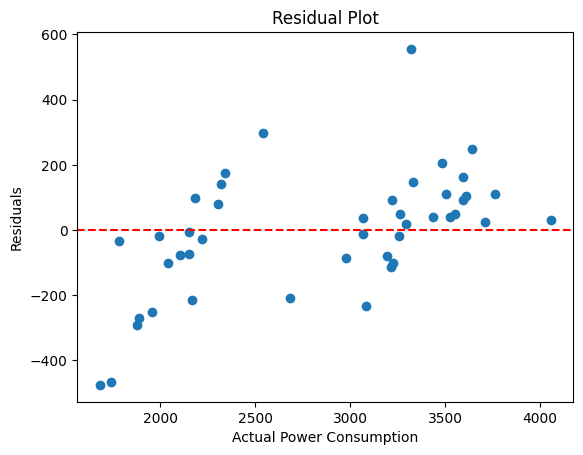

In [26]:
residuals = y_test_rescaled - y_pred_rescaled
plt.scatter(y_test_rescaled, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Power Consumption')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


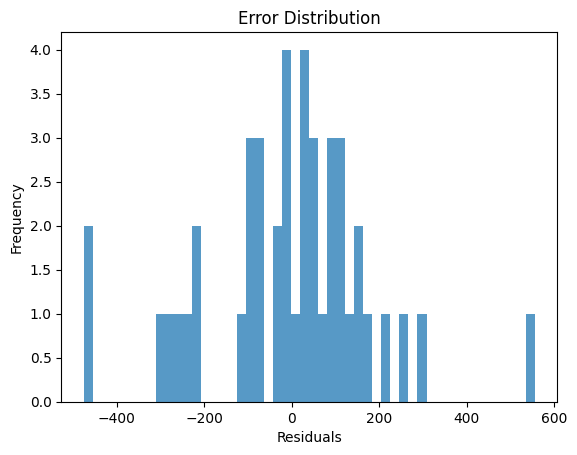

In [27]:
plt.hist(residuals, bins=50, alpha=0.75)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.show()


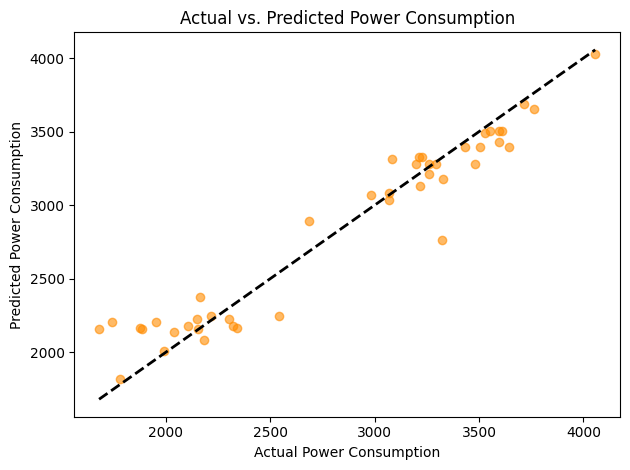

In [28]:
plt.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.6, color='darkorange')
plt.plot([y_test_rescaled.min(), y_test_rescaled.max()],
         [y_test_rescaled.min(), y_test_rescaled.max()], 'k--', lw=2)
plt.xlabel("Actual Power Consumption")
plt.ylabel("Predicted Power Consumption")
plt.title("Actual vs. Predicted Power Consumption")
plt.tight_layout()
plt.show()


In [29]:
X_lingam = df.drop(columns=['average_power_consumption'])


In [30]:
X_lingam_numeric = X_lingam.select_dtypes(include=['float64', 'int64'])

model = DirectLiNGAM()
model.fit(X_lingam_numeric)


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in scalar divide
divide by zero encountered in log
invalid value encountered in divide
divide by zero encountered in log
invalid value encountered in divide
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.413e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=7.071e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=7.033e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 4.215e-08. Red

In [31]:
print("Estimated causal ordering:")
print(model.causal_order_)


Estimated causal ordering:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


In [32]:
causal_order = model.causal_order_
feature_names = X_lingam_numeric.columns
print("Causal order (by name):")
print([feature_names[i] for i in causal_order])


Causal order (by name):
['Unnamed: 0', 'start_time', 'end_time', 'edge', 'meterID', 'processing_time', 'missing_data', 'raw_volume', 'lines_of_code', 'tool_changes', 'travels_to_zero_point_in_rapid_traverse', 'axes_rotation', 'weighted_rotational_speed', 'weighted_tool_diameter', 'weighted_cutting_length', 'weighted_number_of_cutting_edges', 'weighted_cutting_speed', 'weighted_feed_per_tooth', 'weighted_feed_rate']


In [33]:
adjacency_matrix = model.adjacency_matrix_

# print("Causal Structure (Adjacency Matrix):")
# print(adjacency_matrix)

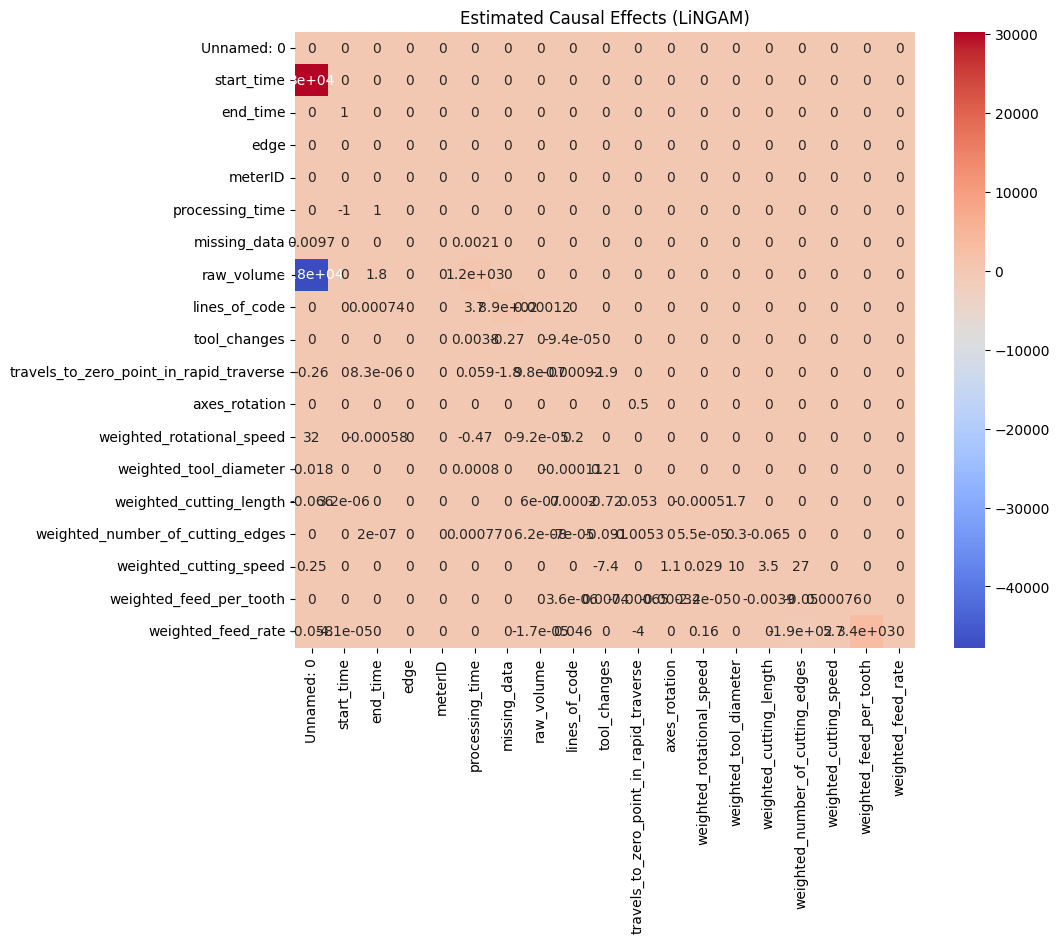

In [34]:
plt.figure(figsize=(10, 8))
sns.heatmap(adjacency_matrix, xticklabels=feature_names, yticklabels=feature_names, annot=True, cmap="coolwarm")
plt.title("Estimated Causal Effects (LiNGAM)")
plt.show()

In [46]:
X_with_target = df.select_dtypes(include=['float64', 'int64'])
model.fit(X_with_target)
adj_matrix = model.adjacency_matrix_
feature_names = df.columns.tolist()
target_index = X_with_target.columns.get_loc('average_power_consumption')
causal_sources = adj_matrix[:, target_index]  
print("Features that cause average power consumption:")
for i, val in enumerate(causal_sources):
    if abs(val) > 0.05:  
        print(f"{X_with_target.columns[i]} → average_power_consumption (effect: {val:.2f})")


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in scalar divide


Features that cause average power consumption:
raw_volume → average_power_consumption (effect: 5132.87)
weighted_rotational_speed → average_power_consumption (effect: -0.89)
weighted_feed_rate → average_power_consumption (effect: -0.07)


divide by zero encountered in log
invalid value encountered in divide
divide by zero encountered in log
invalid value encountered in divide
Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.865e-04, with an active set of 8 regressors, and the smallest cholesky pivot element being 7.300e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=2.865e-04, previous alpha=2.859e-04, with an active set of 8 regressors.


In [47]:
def adjacency_to_edge_list(adj_matrix, feature_names, threshold=0.05):
    edges = []
    for i in range(adj_matrix.shape[0]):
        for j in range(adj_matrix.shape[1]):
            if abs(adj_matrix[i, j]) > threshold and i != j:
                edges.append((feature_names[i], feature_names[j]))
    return edges

def compute_metrics(true_edges, pred_edges):
    true_set = set(true_edges)
    pred_set = set(pred_edges)

    nodes = sorted(set([n for edge in true_set | pred_set for n in edge]))
    node_to_idx = {node: i for i, node in enumerate(nodes)}
    n = len(nodes)

    true_mat = np.zeros((n, n))
    pred_mat = np.zeros((n, n))

    for src, tgt in true_set:
        true_mat[node_to_idx[src], node_to_idx[tgt]] = 1
    for src, tgt in pred_set:
        pred_mat[node_to_idx[src], node_to_idx[tgt]] = 1

    true_flat = true_mat.flatten()
    pred_flat = pred_mat.flatten()

    precision = precision_score(true_flat, pred_flat)
    recall = recall_score(true_flat, pred_flat)
    f1 = f1_score(true_flat, pred_flat)
    shd_val = SHD(nx.DiGraph(true_set), nx.DiGraph(pred_set))

    return precision, recall, f1, shd_val


ground_truth_edges = [
    ("weighted_cutting_speed", "average_power_consumption"),
    ("weighted_rotational_speed", "average_power_consumption"),
    ("processing_time", "average_power_consumption")
]

In [48]:
def compute_metrics(true_edges, pred_edges):
    true_set = set(true_edges)
    pred_set = set(pred_edges)

    all_nodes = sorted(set([n for edge in true_set | pred_set for n in edge]))

    true_graph = nx.DiGraph()
    pred_graph = nx.DiGraph()
    true_graph.add_nodes_from(all_nodes)
    pred_graph.add_nodes_from(all_nodes)
    true_graph.add_edges_from(true_set)
    pred_graph.add_edges_from(pred_set)

    node_to_idx = {node: i for i, node in enumerate(all_nodes)}
    n = len(all_nodes)
    true_mat = np.zeros((n, n))
    pred_mat = np.zeros((n, n))

    for src, tgt in true_set:
        true_mat[node_to_idx[src], node_to_idx[tgt]] = 1
    for src, tgt in pred_set:
        pred_mat[node_to_idx[src], node_to_idx[tgt]] = 1

    true_flat = true_mat.flatten()
    pred_flat = pred_mat.flatten()

    precision = precision_score(true_flat, pred_flat)
    recall = recall_score(true_flat, pred_flat)
    f1 = f1_score(true_flat, pred_flat)
    shd_val = SHD(true_graph, pred_graph)

    return precision, recall, f1, shd_val


In [50]:
lingam_edges = adjacency_to_edge_list(adj_matrix, feature_names)

lingam_precision, lingam_recall, lingam_f1, lingam_shd = compute_metrics(ground_truth_edges, lingam_edges)


In [51]:
print("\n--- LiNGAM Causal Metrics ---")
print(f"Precision: {lingam_precision:.3f}")
print(f"Recall:    {lingam_recall:.3f}")
print(f"F1 Score:  {lingam_f1:.3f}")
print(f"SHD:       {lingam_shd}")


--- LiNGAM Causal Metrics ---
Precision: 0.000
Recall:    0.000
F1 Score:  0.000
SHD:       43


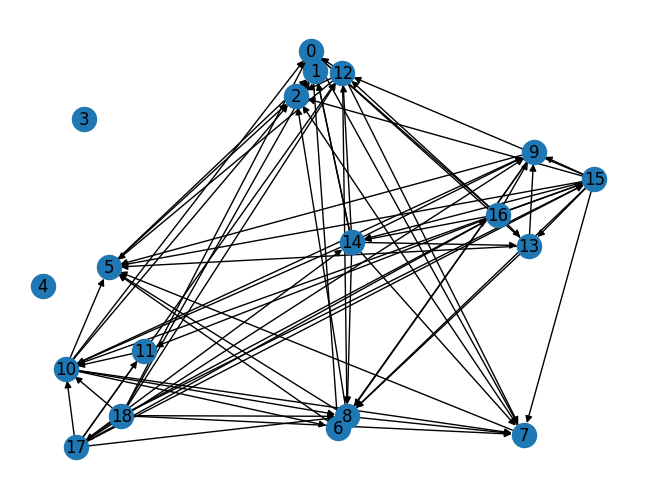

In [52]:
G = nx.DiGraph(adjacency_matrix)
nx.draw(G, with_labels=True)
plt.show()